In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline

In [31]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sb_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sb_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sb_x = np.absolute(sb_x)
    sb_y = np.absolute(sb_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grads = np.arctan2(sb_y, sb_x)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(grads)
    mask[ (grads >= thresh[0]) & (grads < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sb_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sb_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sb_m = np.sqrt( sb_x ** 2 + sb_y ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sb_m = np.uint8( sb_m / np.max(sb_m) * 255 )
    # 5) Create a binary mask where mag thresholds are met
    mask = np.zeros_like(sb_m)
    
    mask[ (sb_m >= mag_thresh[0]) & (sb_m < mag_thresh[1]) ] = 1
    # 6) Return this mask as your binary_output image
    return mask
    
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x': 
        sobeled = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobeled = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    sobeled = np.absolute(sobeled)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobeled = np.uint8(sobeled / np.max(sobeled) * 255.0)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask = np.zeros_like(sobeled)
    mask[(sobeled > thresh[0]) &
         (sobeled < thresh[1])] = 1
    
    return mask

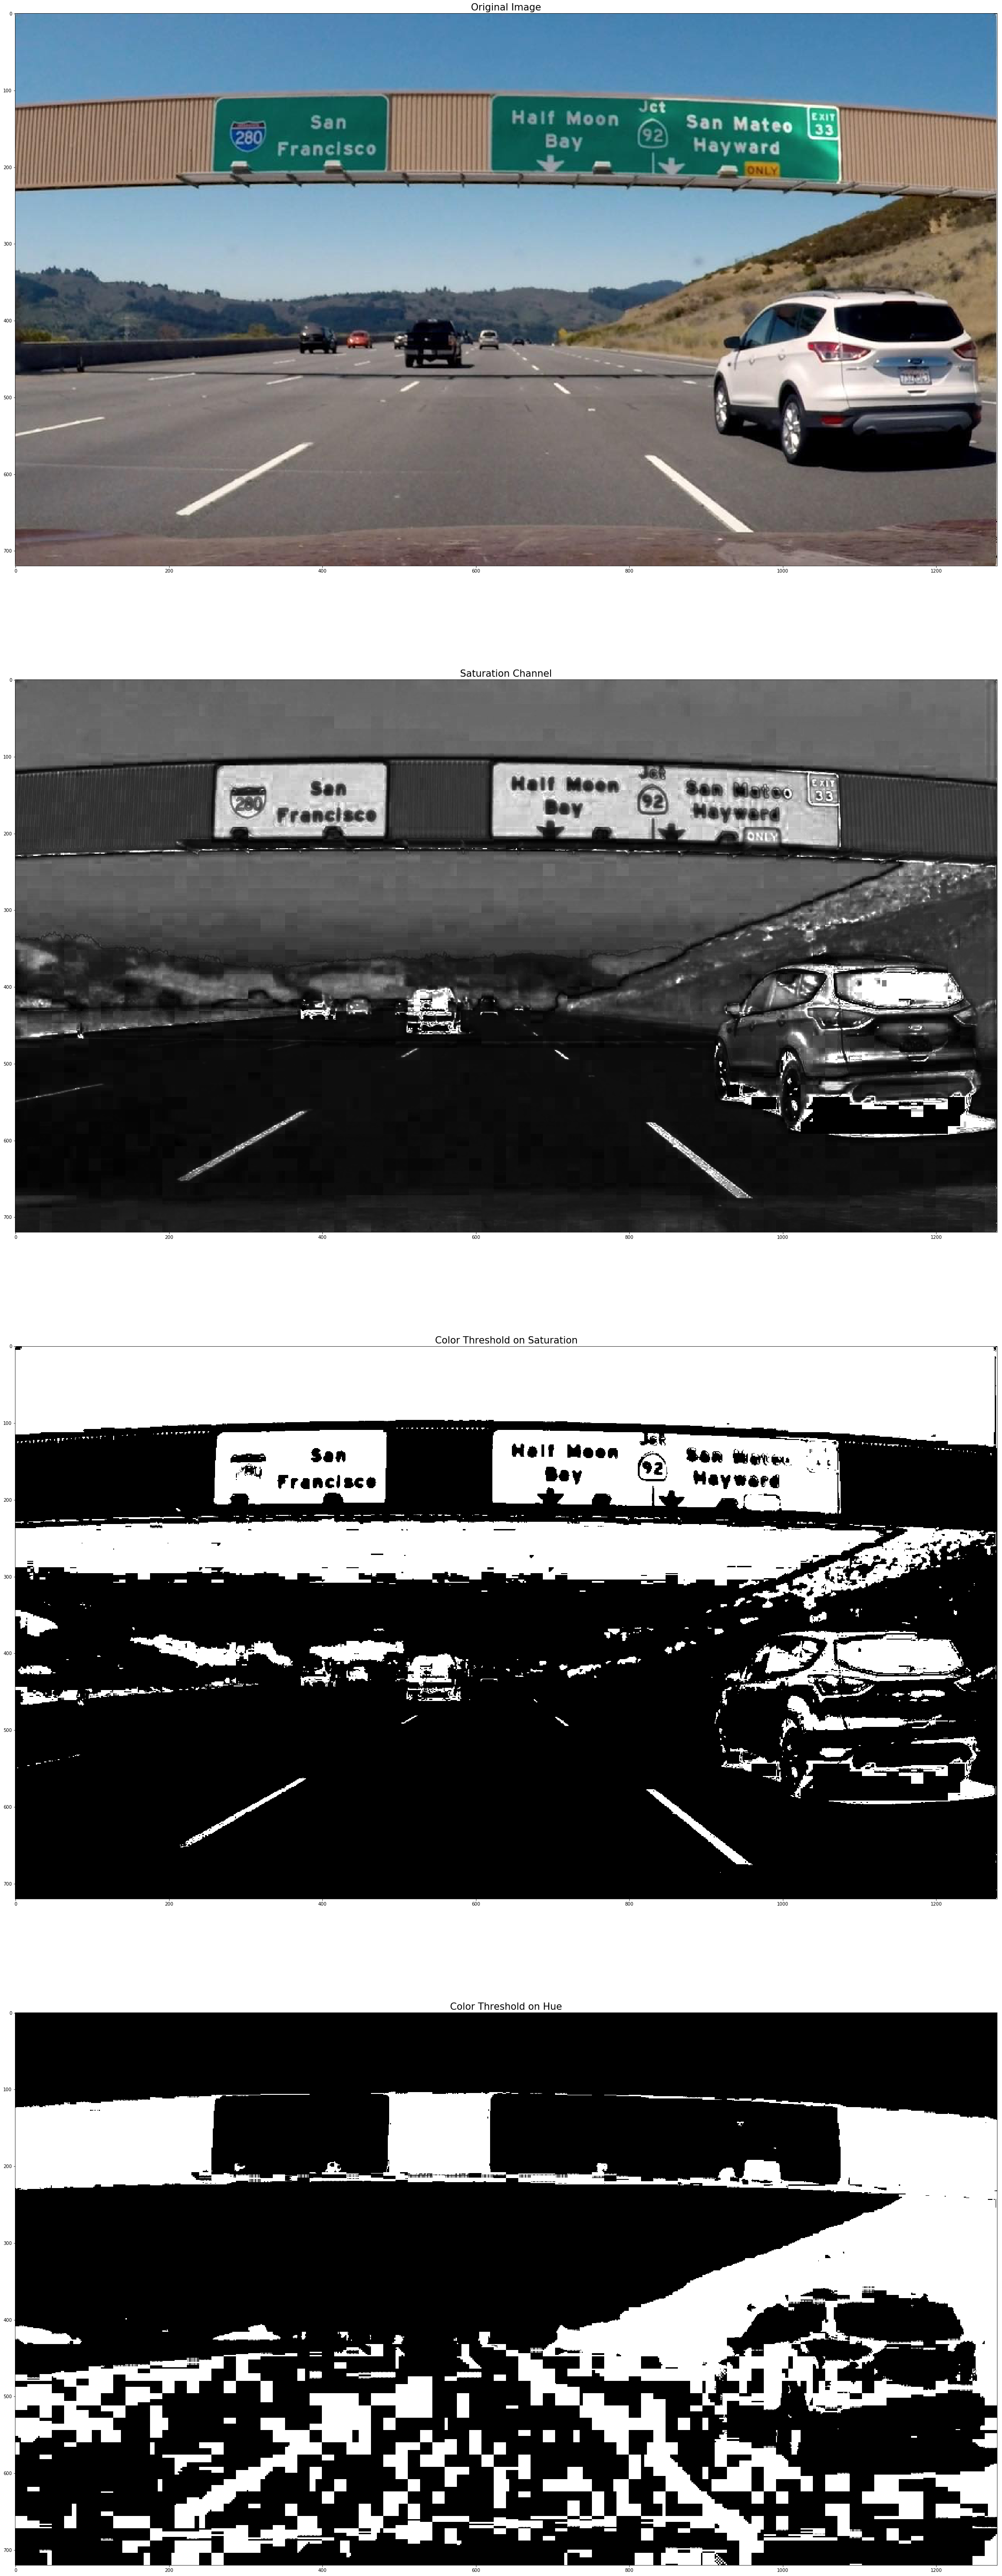

In [57]:
# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')

gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hls   = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

img_h   = hls[:, :, 0]
img_l   = hls[:, :, 1]
img_s   = hls[:, :, 2] * 255.0

t_s = np.zeros_like(img_s)
t_s[(img_s > 90) & (img_s <= 255)] = 1

t_h = np.zeros_like(img_h)
t_h[(img_h > 15) & (img_h < 100)] = 1

# img_r = image[:, :, 0]
# img_g = image[:, :, 1]
# img_b = image[:, :, 2]

ksize = 5

# threshold function
def combined_threshold(image):
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(35, 100))
    mag_binary = mag_thresh(image, sobel_kernel=13, mag_thresh=(20, 255))
    dir_binary = dir_threshold(image, sobel_kernel=7, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[
        (gradx == 1) & 
        (grady == 1) & 
        (mag_binary == 1) & 
        (dir_binary == 1) ] = 1
    return combined


t_gr = combined_threshold(gray)
# t_r  = combined_threshold(img_r)
# t_g  = combined_threshold(img_g)
# t_b  = combined_threshold(img_b)

# Plot the result
f, (ax1, ax2, axr, axg) = plt.subplots(4, 1, figsize=(30, 90))
f.tight_layout()

# 1. Original image
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=21)

ax2.imshow(img_s, cmap='gray')
ax2.set_title('Saturation Channel', fontsize=21)
# 2. Thresholds on grayscale
# ax2.imshow(t_gr, cmap='gray')
# ax2.set_title('Thresholded Gray.', fontsize=21)

# 3. Thresholds on red
# axr.imshow(t_r, cmap='gray')
# axr.set_title('Thresholded Red.', fontsize=21)

# 4. Thresholds on green
# axg.imshow(t_g, cmap='gray')
# axg.set_title('Thresholded Green.', fontsize=21)

# 5. Thresholds on blu
# axb.imshow(t_b, cmap='gray')
# axb.set_title('Thresholded Blue.', fontsize=21)

# 6. Color threshold on S
axr.imshow(t_s, cmap='gray')
axr.set_title("Color Threshold on Saturation", fontsize=21)

axg.imshow(t_h, cmap='gray')
axg.set_title("Color Threshold on Hue", fontsize=21)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
